## **Image Classification**


1. MNIST 데이터셋을 제외한 다른 공공 데이터셋 선택
2. 해당 데이터셋에 대하여 MLP와 CNN으로 Image Classification 수행
3. ~ipynb 코드 제출 (코드와 실행내용 모두 있어야 함)

&#9989; 해당 파일은 CNN 으로 Image Classification 수행한 내용입니다.

In [ ]:
import torch
import pandas as pd
import numpy as np
import random
import os
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from PIL import Image
import torchvision

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# parameters
learning_rate = 0.01
epochs = 3
batch_size = 128
drop_out = 0.3

### 1. 데이터셋 선택

- 캐글 Dogs vs. Cats 데이터, 개와 고양이 분류    
링크: https://www.kaggle.com/competitions/dogs-vs-cats

In [ ]:
# save the directories of the datasets to variables
train_dir = "/content/drive/MyDrive/data/train/train/"
test_dir = "/content/drive/MyDrive/data/test/"
# check the format of the data
train_image_names = os.listdir(train_dir)
test_image_names = os.listdir(test_dir)

print(train_image_names[:3])
print(test_image_names[:3])

['dog.8643.jpg', 'dog.8655.jpg', 'dog.8652.jpg']
['1001.jpg', '10009.jpg', '10010.jpg']


In [ ]:
# make lists of dataset images with their full path
import glob

train_images = glob.glob(os.path.join(train_dir, "*.jpg"))
test_images = glob.glob(os.path.join(test_dir, "*.jpg" ))

print(train_images[:3])
print(len(train_images))
print(test_images[:3])
print(len(test_images))

['/content/drive/MyDrive/data/train/train/dog.8643.jpg', '/content/drive/MyDrive/data/train/train/dog.8655.jpg', '/content/drive/MyDrive/data/train/train/dog.8652.jpg']
15122
['/content/drive/MyDrive/data/test/1001.jpg', '/content/drive/MyDrive/data/test/10009.jpg', '/content/drive/MyDrive/data/test/10010.jpg']
450


In [ ]:
# test data 에 라벨이 없어서 train 데이터를 train, val data로 나누고 검증용(val)데이터를 이용해 정확도 확인
from sklearn.model_selection import train_test_split

train_list, val_list = train_test_split(train_images, test_size=0.2)

In [ ]:
# make a dataset class
class CatDogDataset(Dataset):
    
    def __init__(self, images_list, mode="train", transform=None):
        self.images_list = images_list
        self.mode = mode
        self.transform = transform
        
    # dataset length
    def __len__(self):
        self.dataset_len = len(self.images_list)
        return self.dataset_len
    
    # load an image
    def __getitem__(self, idx):
        image_name = self.images_list[idx]
        image = Image.open(image_name)
        image = image.resize((224,224)) # this is important when feeding into a pretrained model
        transformed_image = self.transform(image)
        image_category = image_name.split("/")[-1].split(".")[0]
        
        if self.mode == "train" or self.mode == "val":
            if image_category == "cat":
                label = 0 
            else:
                label = 1              
            return transformed_image, label
        else:
            return transformed_image

In [ ]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224, scale=(0.8,1.0),ratio=(1.0,1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [ ]:
# create dataset objects
train_dataset = CatDogDataset(train_list, transform=transform)
val_dataset = CatDogDataset(val_list, mode="val", transform=transform)
test_dataset = CatDogDataset(test_images, mode="val", transform=transform)

In [ ]:
# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

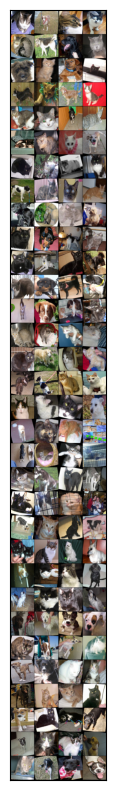

In [ ]:
# visualize several random images
for images, labels in train_dataloader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1,2,0))
    break

### 2. 신경망, CNN 

In [ ]:
# device check
print(device)

cuda


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
    self.conv4 = nn.Conv2d(64, 128, 3, 2)
    self.pool = nn.MaxPool2d(2, 2)
    self.dout = nn.Dropout(drop_out)
    self.fc1 = nn.Linear(128*6*6, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 2)

  def forward(self, out):
    out = self.pool(nn.functional.relu(self.conv1(out)))
    out = self.pool(nn.functional.relu(self.conv2(out)))
    out = self.pool(nn.functional.relu(self.conv3(out)))
    out = self.pool(nn.functional.relu(self.conv4(out)))
    out = self.dout(out)
    out = out.view(out.size(0), -1)
    out = nn.functional.relu(self.fc1(out))
    out = self.dout(out)
    out = nn.functional.relu(self.fc2(out))
    out = self.dout(out)
    out = self.fc3(out)
    return out

In [ ]:
model = CNN().to(device)

In [ ]:
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_batch = len(train_dataloader)
print(f'{total_batch}, Learning started. It takes sometime.')

model.train()

for epoch in range(epochs):
    avg_loss = 0     
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device) 
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
            
        loss.backward()
        optimizer.step()
    
        avg_loss += loss / total_batch
        
      
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_loss))

print('Learning Finished!')

95, Learning started. It takes sometime.
[Epoch:    1] cost = 0.688546777
[Epoch:    2] cost = 0.688342631
[Epoch:    3] cost = 0.688509047
Learning Finished!


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    model.eval()    
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy : {100 * correct // total} %')

Accuracy : 54 %


label :  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


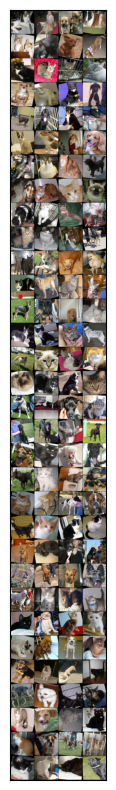

In [ ]:
for X_test, Y_test in test_dataloader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1,2,0))

    X_test, Y_test = X_test.to(device), Y_test.to(device)
    prediction = model(X_test)
    _, predicted = torch.max(prediction.data, 1)
    
    print( 'label : ' , predicted)
    break

# 검증용 데이터로 평가 결과 54% 되는 모델의 test data 예측 결과 모두 고양이(label : 0) 로 예측하였는데, 
# 강아지도 고양이로 예측한 것을 사진과 비교해서 알 수 있다. 
# 모델의 정확도를 높이기 위한 파라미터 조정 및 조치가 필요하다.